
# Project: Investigate a Dataset - European Soccer Database

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

The ultimate Soccer database for data analysis and machine learning : https://www.kaggle.com/hugomathien/soccer
These are the tables and the columns we will need to answer our questions:

>Match  

>Team

### Question(s) for Analysis
We will try to answer the following quesions : 
> 1-Which team has the most number of wins every season ?

> 2-Which team has the most number of losses every season ?

> 3-How have teams improved from 2008/2009 to 2015/2016 season ?

> 4-Which team have improved the most  2008/2009 to 2015/2016 season ? 

> 5-Which team have degraded the most  2008/2009 to 2015/2016 season ? 


In [544]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

%matplotlib inline


<a id='wrangling'></a>
## Data Wrangling

> In the next section we will load our data and do the necessary cleaning for each table

In [545]:
database_path = 'E:\courses\DataAnalysis\Course2\DataAnalysis\project\database\database.sqlite'
match_data_sql_query = 'select id , country_id , league_id , season , home_team_api_id , away_team_api_id , home_team_goal , away_team_goal from Match' 
team_data_sql_query = 'select * from Team'

#connecting to the database
connect = sqlite3.connect(database_path)
  
# getting tables data
match_df = pd.read_sql(match_data_sql_query, connect)
team_df = pd.read_sql(team_data_sql_query, connect)


In [546]:
match_df.head()

,id,country_id,league_id,season,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
0,1,1,1,2008/2009,9987,9993,1,1
1,2,1,1,2008/2009,10000,9994,0,0
2,3,1,1,2008/2009,9984,8635,0,3
3,4,1,1,2008/2009,9991,9998,5,0
4,5,1,1,2008/2009,7947,9985,1,3


In [547]:
team_df.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB



### Data Cleaning
> After we loaded our data we will clean our data from dublicated and null values
 

In [548]:
#no need to clean match table as there is no null or dublicated values
match_df.info()
sum(match_df.duplicated())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                25979 non-null  int64 
 1   country_id        25979 non-null  int64 
 2   league_id         25979 non-null  int64 
 3   season            25979 non-null  object
 4   home_team_api_id  25979 non-null  int64 
 5   away_team_api_id  25979 non-null  int64 
 6   home_team_goal    25979 non-null  int64 
 7   away_team_goal    25979 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 1.6+ MB


0

No dublicated data and no missing values exist in our table , no need for cleaning

In [549]:
team_df.info()  #no need to use team_fifa_api_id column , so we will drop it

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                299 non-null    int64  
 1   team_api_id       299 non-null    int64  
 2   team_fifa_api_id  288 non-null    float64
 3   team_long_name    299 non-null    object 
 4   team_short_name   299 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 11.8+ KB


team_fifa_api_id  has alot of missing values and it`s not needed in our analysis so we will drop it

In [550]:
#Dropping team_fifa_api_id column
dropped_columns = ['team_fifa_api_id' ]

In [551]:
sum(team_df.duplicated()) # 0 duplicates , no need to drop duplicates

0

No dublicate values

### Transforming and adding data to our table to help in our analysis

In [552]:
# Adding a column to specify which team have won the match
# we will put the id of the team winning , if it`s a draw we will put -1
match_df['winning_team_api_id'] = match_df['home_team_api_id']
match_df.loc[match_df['home_team_goal'] < match_df['away_team_goal'], 'winning_team_api_id'] = match_df['away_team_api_id']
match_df.loc[match_df['home_team_goal'] == match_df['away_team_goal'], 'winning_team_api_id'] = -1

We added a new column in match table which specifies which team have won the match

In [553]:
# Adding a column to specify which team have lost the match
# we will put the id of the team losing , if it`s a draw we will put -1
match_df['losing_team_api_id'] = match_df['away_team_api_id']
match_df.loc[match_df['home_team_goal'] < match_df['away_team_goal'], 'losing_team_api_id'] = match_df['home_team_api_id']
match_df.loc[match_df['home_team_goal'] == match_df['away_team_goal'], 'losing_team_api_id'] = -1


We added a new column in match table which specifies which team have lost the match

<a id='eda'></a>
## Exploratory Data Analysis

> Now we will try to answer our questions in the introduction


### Research Question 1 : Which team has the most number of wins every season ?  
### Research Question 2 : Which team has the most number of losses every season ?    

In [554]:

def arr_to_str(arr) :
    """
    Converts an array to string
    Arguments:
        arr: the array to be converted to string
    Returns:
        The elements of the array in one string separated by line
    """
    s = ""
    for i in arr :
        s += i
        s += '\n'
    
    return s

First let`s explore our data and check How many goals are scored in different fields ('Home' , 'Away')

In [555]:
match_df['home_team_goal'].describe()

count    25979.000000
mean         1.544594
std          1.297158
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         10.000000
Name: home_team_goal, dtype: float64

Mean of number of goals scored in Home field = 1.7322911829954084

In [556]:
match_df['away_team_goal'].describe()

count    25979.000000
mean         1.160938
std          1.142110
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          9.000000
Name: away_team_goal, dtype: float64

Mean of number of goals scored in Away field = 1.2180776969509364

In [557]:
match_df = match_df.drop(match_df[match_df['losing_team_api_id'] == -1].index)
match_df = match_df.drop(match_df[match_df['winning_team_api_id'] == -1].index)

In [558]:
#getting names of the teams with most wins every season
most_winning_teams = match_df.groupby('season')['winning_team_api_id'].agg(pd.Series.mode) #teams with the most wins
most_wins_count = match_df.groupby(['season','winning_team_api_id']).count() #count of number of wins every season
most_wins_seasons = most_wins_count.groupby('season')['id'].max().keys() #names of the seasons
most_wins_count = most_wins_count.groupby('season')['id'].max().values #count of max number of wins every season


In [559]:
most_losing_teams = match_df.groupby('season')['losing_team_api_id'].agg(pd.Series.mode) #teams with the most losses
most_losses_count = match_df.groupby(['season','losing_team_api_id']).count() #count of number of losses every season
most_losses_seasons = most_losses_count.groupby('season')['id'].max().keys() #names of the seasons
most_losses_count = most_losses_count.groupby('season')['id'].max().values #count of max number of losses every season


In [560]:
#Getting the team name from the team id
most_winning_teams_names = np.empty(len(most_winning_teams.values) , dtype = object)
i = 0
for id in most_winning_teams :
    if type(id) is np.int64:
        most_winning_teams_names[i] = team_df[team_df['team_api_id'] == id]['team_long_name'].values 
    else :
        most_winning_teams_names[i] = team_df[team_df['team_api_id'].isin(id)]['team_long_name'].values
    i += 1
most_winning_teams_names


array([array(['Manchester United'], dtype=object),
       array(['Real Madrid CF', 'FC Barcelona'], dtype=object),
       array(['Rangers', 'FC Barcelona'], dtype=object),
       array(['Real Madrid CF'], dtype=object),
       array(['FC Barcelona'], dtype=object),
       array(['Juventus'], dtype=object),
       array(['Real Madrid CF', 'FC Barcelona'], dtype=object),
       array(['Paris Saint-Germain'], dtype=object)], dtype=object)

In [561]:
#Getting the team name from the team id
most_losing_teams_names = np.empty(len(most_losing_teams.values) , dtype = object)
i = 0
for id in most_losing_teams :
    if type(id) is np.int64:
        most_losing_teams_names[i] = team_df[team_df['team_api_id'] == id]['team_long_name'].values
    else :
        most_losing_teams_names[i] = team_df[team_df['team_api_id'].isin(id)]['team_long_name'].values
    i += 1
most_losing_teams_names


array([array(['Le Havre AC'], dtype=object),
       array(['RKC Waalwijk'], dtype=object),
       array(['Willem II', 'VVV-Venlo'], dtype=object),
       array(['Blackburn Rovers', 'Wolverhampton Wanderers', 'Excelsior',
              'Dunfermline Athletic'], dtype=object)                     ,
       array(['Pescara'], dtype=object),
       array(['FC Lausanne-Sports'], dtype=object),
       array(['St. Mirren'], dtype=object),
       array(['Aston Villa'], dtype=object)], dtype=object)

In [562]:
#converting teams names from array format to string format to prepare for plot
i = 0
for name in most_winning_teams_names :
    most_winning_teams_names[i] = arr_to_str(name)
    i += 1
i=0
for name in most_losing_teams_names :
    most_losing_teams_names[i] = arr_to_str(name)
    i += 1


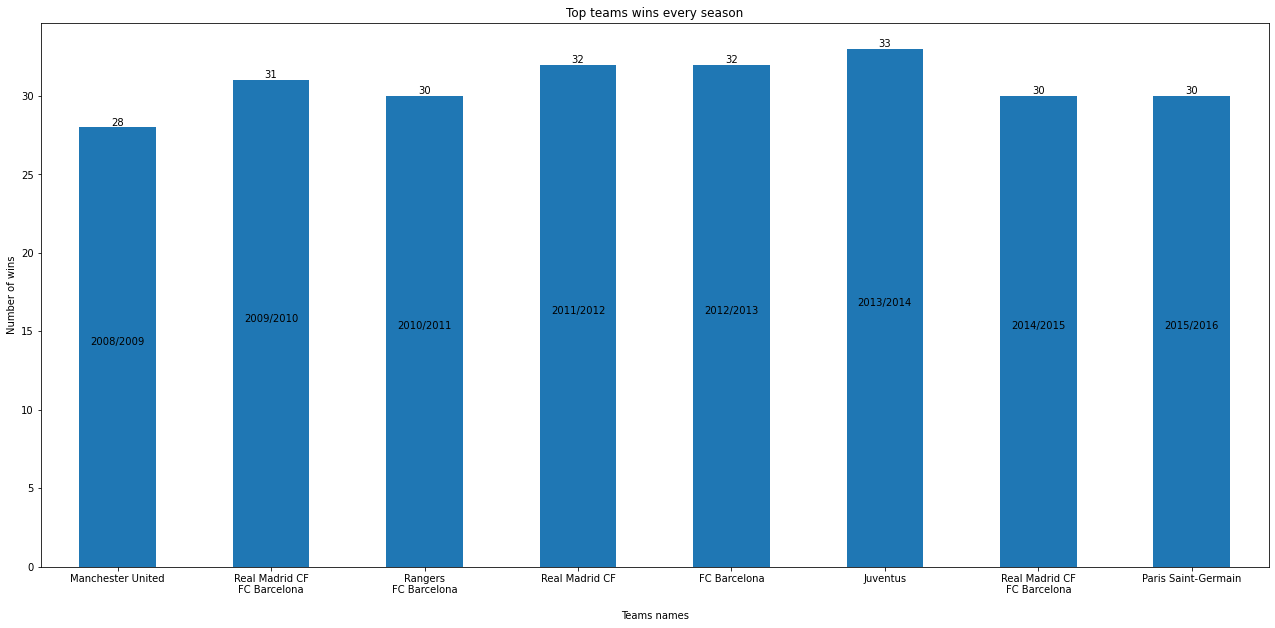

In [563]:
# preparing data for plotting
#Heights
frequencies = most_wins_count
freq_series = pd.Series(frequencies)
#x axis labels
x_labels = most_winning_teams_names

# Plot the figure.
plt.figure(figsize=(22, 10))
ax = freq_series.plot(kind="bar")
ax.set_title("Top teams wins every season")
ax.set_xlabel("Teams names")
ax.set_ylabel("Number of wins")
ax.set_xticklabels(x_labels , rotation = 0)

rects = ax.patches

# Make some labels.
labels = most_wins_seasons

#Adding labels for seasons names inside the bars
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height - height/2 , label, ha="center", va="bottom"
    )

#Adding labels for number of wins count over the bars
for rect, frequency in zip(rects, frequencies):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height , frequency, ha="center", va="bottom"
    )
        


plt.show()

<a id = 'Top_teams_wins_every_season' ></a>
In the previews bar plot we showed which teams have the most number of wins every season , where in each bar we show the season year and the team which had the most number of wins and the number of wins it had that season 

For example : Manchester United was the team that had the most number of wins in 2008/2009 with 28 wins

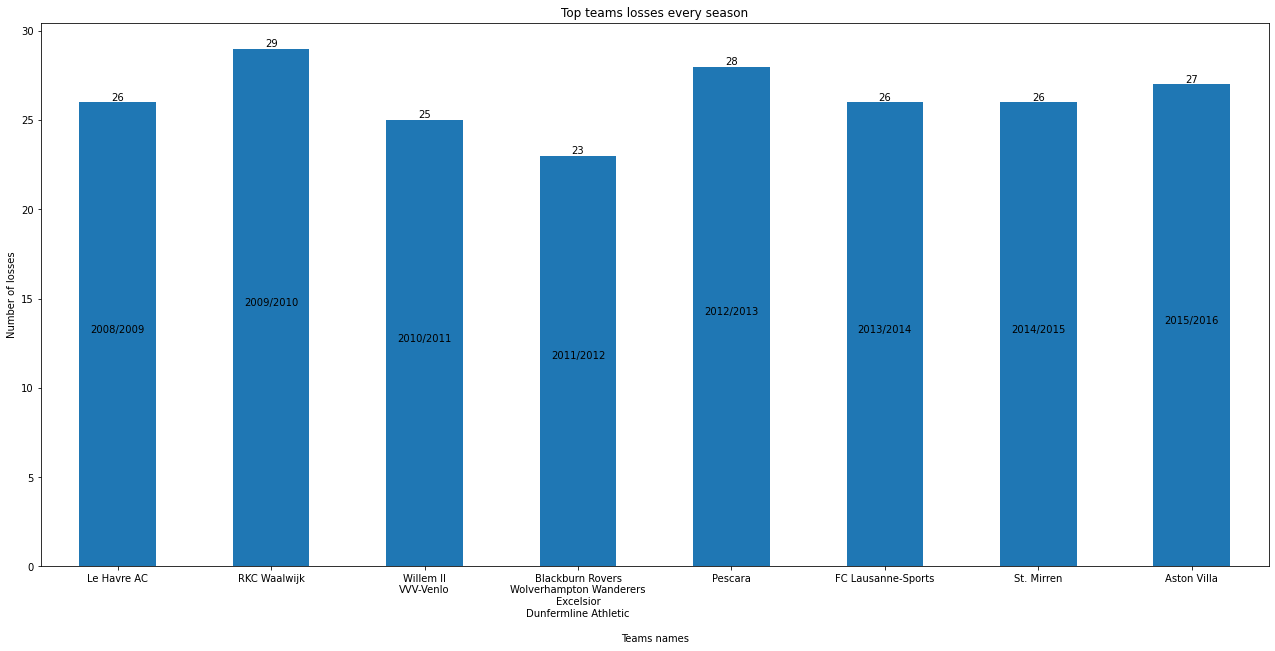

In [564]:
# Bring some raw data.
frequencies = most_losses_count
# In my original code I create a series and run on that,
# so for consistency I create a series from the list.
freq_series = pd.Series(frequencies)

x_labels = most_losing_teams_names

# Plot the figure.
plt.figure(figsize=(22, 10))
ax = freq_series.plot(kind="bar")
ax.set_title("Top teams losses every season")
ax.set_xlabel("Teams names")
ax.set_ylabel("Number of losses")
ax.set_xticklabels(x_labels , rotation = 0)

rects = ax.patches

# Make some labels.
labels = most_losses_seasons

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height - height/2 , label, ha="center", va="bottom"
    )
    
for rect, frequency in zip(rects, frequencies):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height , frequency, ha="center", va="bottom"
    )
        


plt.show()

<a id = 'Top_teams_losses_every_season' ></a>

In the previews bar plot we showed which teams have the most number of losses every season , where in each bar we show the season year and the team which had the most number of wins and the number of losses it had that season

For example : Le Havre AC was the team that had the most number of Losses in 2008/2009 with 26 losses

### Research Question 3-How have teams improved from 2008/2009 to 2015/2016 season ?

In [565]:
#getting the count of wins of each team 
teams_wins_count = match_df.groupby(['season','winning_team_api_id']).count()['id'].reset_index()
teams_wins_count = teams_wins_count.rename(columns = {'id' : 'wins_count' , 'winning_team_api_id':'team_api_id'})

#getting the count of wins in 2008/2009 and 2015/2016 seasons
teams_wins_count_2008 = teams_wins_count.query("season == '2008/2009'")
teams_wins_count_2008 = teams_wins_count_2008.rename(columns = {'wins_count' : 'wins_count_2008'})
teams_wins_count_2016 =  teams_wins_count.query("season == '2015/2016'")
teams_wins_count_2016 = teams_wins_count_2016.rename(columns = {'wins_count' : 'wins_count_2016'})

Let`s see the distribution of number of wins in both seasons

Text(0, 0.5, 'Number of wins')

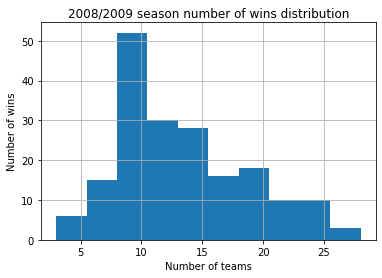

In [566]:
teams_wins_count_2008['wins_count_2008'].plot(kind = 'hist' , 
                                             grid = True ,
                                             title = '2008/2009 season number of wins distribution')
plt.xlabel('Number of teams')
plt.ylabel('Number of wins')

Text(0, 0.5, 'Number of wins')

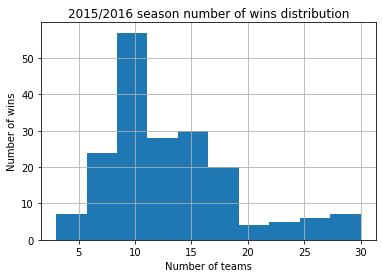

In [567]:
teams_wins_count_2016['wins_count_2016'].plot(kind = 'hist' , 
                                             grid = True ,
                                             title = '2015/2016 season number of wins distribution')
plt.xlabel('Number of teams')
plt.ylabel('Number of wins')

<a id = 'season_wins_distribution' ></a>

As we can see from the previews two distributions , the distribution of number of wins in both seasons is almost the same in the center of the distribution , but it has slight differences on the edges

In [568]:
#adding the count of wins in 2008/2009 and 2015/2016 seasons in the same row
team_wins_count_2008_2016 = pd.merge(teams_wins_count_2008,teams_wins_count_2016, how = 'inner' ,left_on=['team_api_id'] , right_on=['team_api_id'])
dropped_columns = ['season_x' , 'season_y']
team_wins_count_2008_2016.drop(dropped_columns , axis = 1 , inplace = True)
team_wins_count_2008_2016

,team_api_id,wins_count_2008,wins_count_2016
0,1601,9,11
1,1957,9,10
2,2182,16,13
3,2186,7,12
4,6403,9,13
...,...,...,...
126,10261,7,9
127,10264,13,16
128,10265,19,8
129,10267,18,11


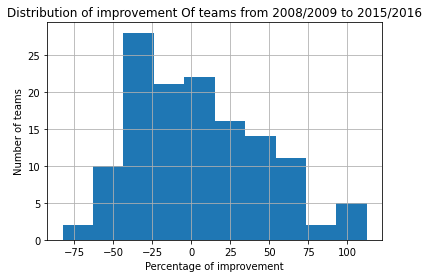

In [569]:
#calculating the improvement
team_wins_count_2008_2016['improvement'] = team_wins_count_2008_2016['wins_count_2016']/team_wins_count_2008_2016['wins_count_2008']
team_wins_count_2008_2016['improvement'] = team_wins_count_2008_2016['improvement']*100 - 100
team_wins_count_2008_2016['improvement'].plot(kind = 'hist' ,
                                              grid = True,
                                             title = 'Distribution of improvement Of teams from 2008/2009 to 2015/2016');
plt.xlabel('Percentage of improvement')
plt.ylabel('Number of teams')
plt.show()

<a id = 'improvements_distribution' ></a>

In this plot we show the distribution of how the teams improved over the years from 2008/2009 season to 2015/2016 season 
where in x axis we show the percentage of improvement and in y axis we show how many teams had this amount of improvement.

For example : Roughly 5 teams have improved by 100 % 

### Research Question 4-Which team have improved the most  2008/2009 to 2015/2016 season ? 

In [570]:
team_wins_count_2008_2016 = pd.merge(team_wins_count_2008_2016, team_df, on ='team_api_id', how ="inner")
print('Most improved team from 2008/2009 season to 2015/2016 season')
team_wins_count_2008_2016[team_wins_count_2008_2016['improvement'] == team_wins_count_2008_2016['improvement'].max()]

Most improved team from 2008/2009 season to 2015/2016 season


,team_api_id,wins_count_2008,wins_count_2016,improvement,id,team_fifa_api_id,team_long_name,team_short_name
67,9788,8,17,112.5,15631,23.0,Borussia Mönchengladbach,GLA


As we ca see from the previews data ,  Borussia Mönchengladbach	 was the team that have improved the most from 2008/2009 to 2015/2016 , as it has improved by 112.5 %

### Research Question 5-Which team have degraded the most  2008/2009 to 2015/2016 season ? 

In [571]:
print('Most degraded team from 2008/2009 season to 2015/2016 season')
team_wins_count_2008_2016[team_wins_count_2008_2016['improvement'] == team_wins_count_2008_2016['improvement'].min()]

Most degraded team from 2008/2009 season to 2015/2016 season


,team_api_id,wins_count_2008,wins_count_2016,improvement,id,team_fifa_api_id,team_long_name,team_short_name
124,10252,17,3,-82.352941,3465,2.0,Aston Villa,AVL


As we ca see from the previews data ,  Aston Villa	 was the team that have degraded the most from 2008/2009 to 2015/2016 , as it has degraded by 82.352941%

<a id='conclusions'></a>
## Conclusions

### Here are the key points of our sythesis



> Being in you home field has more advantage than being in away field as we saw from our analysis , mean of number of goals in Home field = 1.732 and mean of number of goals in Away field = 1.218   it makes sense because in your home field you have more fans than you your opponent which can encourage you to score more goals

> Most number of wins every season: [You can see the graph here](#Top_teams_wins_every_season)  

>2008/2009 season -- > Manchester United with 28 wins  ,  Results are accurate as we can see from wikipedia : [here](https://en.wikipedia.org/wiki/2008%E2%80%9309_Premier_League)

>2009/2010 season -- > Real Madrid CF ,  FC Barcelona with 31 wins  , Results are accurate as we can see from wikipedia : [here](https://en.wikipedia.org/wiki/2009%E2%80%9310_La_Liga) 

>2010/2011 season -- > Rangers ,  FC Barcelona with 30 wins  , Results are accurate as we can see from wikipedia : [here](https://en.wikipedia.org/wiki/2010%E2%80%9311_La_Liga)  

>2011/2012 season -- > Real Madrid CF with 32 wins  , Results are accurate as we can see from wikipedia : [here](https://en.wikipedia.org/wiki/2011%E2%80%9312_La_Liga)  

>2012/2013 season -- > FC Barcelona with 32 wins  , Results are accurate as we can see from wikipedia : [here](https://en.wikipedia.org/wiki/2011%E2%80%9312_La_Liga)  

>2013/2014 season -- > Juventus with 33 wins  , Results are accurate as we can see from wikipedia : [here](https://en.wikipedia.org/wiki/2013%E2%80%9314_Serie_A) 

>2014/2015 season -- > Real Madrid CF ,  FC Barcelona with 30 wins , Results are accurate as we can see from wikipedia : [here](https://en.wikipedia.org/wiki/2014%E2%80%9315_La_Liga)  

>2015/2016 season -- > Paris Saint-Germain with 30 wins , Results are accurate as we can here : [here](https://terrikon.com/soccer/france/championship/2015-16/table)  


>we can see that the top number of wins range from 28 --> 33  




>Most number of losses every season : [You can see the graph here](#Top_teams_losses_every_season)  

>2008/2009 season -- > Le Havre AC with 26 losses  ,  Results are accurate as we can here : [here](https://fbref.com/en/squads/5c2737db/2008-2009/Le-Havre-Stats)  

>2009/2010 season -- > RKC Waalwijk with 29 losses  , Results are accurate as we can here : [here](https://nl.wikipedia.org/wiki/RKC_Waalwijk_in_het_seizoen_2009/10) 

>2010/2011 season -- > Willem II ,  VVV-Venlo with 25 losses  , Results are accurate as we can here : [here](https://tribuna.com/en/clubs/willem-ii/table/2010-2011/) 

>2011/2012 season -- > Blackburn Rovers,  Wolverhampton Wanderers ,  Excelsior ,  Dunfermline Athletic with 23 losses  , Results are accurate as we can here : [here](https://fbref.com/en/squads/e090f40b/2011-2012/Blackburn-Rovers-Stats) 

>2012/2013 season -- > Pescara  with 28 losses  , Results are accurate as we can here : [here](https://en.wikipedia.org/wiki/2012%E2%80%9313_Delfino_Pescara_1936_season) 

>2013/2014 season -- > FC Lausanne-Sports with 26 losses  , Results are accurate as we can here : [here](https://fbref.com/en/squads/2864c5a0/2013-2014/s692/Lausanne-Sport-Stats-Swiss-Super-League) 

>2014/2015 season -- > St. Mirren with 26 losses  , Results are accurate as we can here : [here](https://en.wikipedia.org/wiki/2014%E2%80%9315_St_Mirren_F.C._season) 

>2015/2016 season -- > Aston Villa with 27 losses  , Results are accurate as we can here : [here](https://en.wikipedia.org/wiki/2015%E2%80%9316_Aston_Villa_F.C._season) 

>we can see that the top number of losses range from 23 --> 29

> Distributions of number of wins in 2008/2009 and 2015/2016 do not have major changes as the distributions are almost the same as we can see from this distribution [here](#season_wins_distribution)

>More teams have degraded by 1% - 50% , less teams have improved by 1% - 50% .

>Team have improved the most  2008/2009 to 2015/2016 season : Borussia Mönchengladbach

>Team have degraded the most  2008/2009 to 2015/2016 season : Aston Villa


### Limitations and assumptions : 
> I assume that data of matches is complete and accurate and there is no need to collect more data about the matches for the specified seasons.
> I assume that improvement is calculated only by the number of wins .

### How it can be improved ?
> it could be improved by adding the number of losses and number of draws in the calculation.

In [501]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

1